# Homework 3

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

#### Notation Commands

$$\newcommand{\cpn}{\text{c}}$$
$$\newcommand{\Tunder}{T_\text{bond}}$$
$$\newcommand{\accint}{\xi}$$
$$\newcommand{\convert}{\psi}$$
$$\newcommand{\ctd}{\text{ctd}}$$

$$\newcommand{\refrate}{r^{\text{ref}}}$$
$$\newcommand{\pfwd}{P_{\text{fwd}}}$$
$$\newcommand{\grossbasis}{B}$$
$$\newcommand{\netbasis}{\tilde{\grossbasis}}$$
$$\newcommand{\pnl}{\Pi}$$

$$\newcommand{\years}{\tau}$$
$$\newcommand{\yearsACT}{\years_{\text{act/360}}}$$

$$\newcommand{\fwdprice}{\mathcal{F}_{t\to T}}$$
$$\newcommand{\futprice}{F_{t\to T}}$$

$$\newcommand{\fwdpriceT}{\mathcal{F}_{T\to T}}$$
$$\newcommand{\futpriceT}{F_{T\to T}}$$

$$\newcommand{\fwdpriceDT}{\mathcal{F}_{t+h\to T}}$$
$$\newcommand{\futpriceDT}{F_{t+h\to T}}$$

$$\newcommand{\rrepo}{r^{\text{repo}}}$$
$$\newcommand{\carry}{\widetilde{\cpn}}$$

***

# 1. Trading Bonds

### Data

The file `data/fut_bond_data_TYZ4_2024-08-01.xlsx` has market data on the following:
* 10-year Treasury future, expiring December 2024
* The specifications of the deliverable treasury bonds

Suppose the present date is `2024-08-01`.

In [125]:
import pandas as pd

futures_data = pd.read_excel("../data/fut_bond_data_TYZ4_2024-08-01.xlsx", sheet_name="future")
bond_data = pd.read_excel("../data/fut_bond_data_TYZ4_2024-08-01.xlsx", sheet_name="bonds")

In [126]:
futures_data

,field,TYZ4 Comdty
0,last_update_dt,2024-08-02 00:00:00
1,px_last,114.234375
2,last_tradeable_dt,2024-12-19 00:00:00
3,fut_dlv_dt_last,2024-12-31 00:00:00
4,fut_days_expire,139
5,fut_ctd,T 4.25 06/30/31
6,fut_ctd_px,103.296875
7,fut_ctd_gross_basis,-9.67291
8,fut_ctd_net_basis,2.684063


In [127]:
bond_data.head()

,ticker,last_update_dt,px_last,maturity,days_to_mty,dur_adj_mid,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion
0,91282CCS Govt,2024-08-02,84.843750,2031-08-15,2566,6.550426,1.250,2024-08-15,10,0.590659,182,172,46.253746,3.646209,5.375,0.7474
1,91282CDJ Govt,2024-08-02,85.062500,2031-11-15,2658,6.763513,1.375,2024-11-15,102,0.306386,184,82,55.779000,3.623413,5.375,0.7463
2,91282CDY Govt,2024-08-02,87.796875,2032-02-15,2750,6.816994,1.875,2024-08-15,10,0.885989,182,172,65.717750,3.675354,5.375,0.7670
3,91282CEP Govt,2024-08-02,94.078125,2032-05-15,2840,6.820612,2.875,2024-11-15,102,0.640625,184,82,75.048750,3.644107,5.375,0.8184
4,91282CFF Govt,2024-08-02,93.000000,2032-08-15,2932,6.990905,2.750,2024-08-15,10,1.299451,182,172,86.003250,3.692673,5.375,0.8060


In [128]:
bond_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ticker                          8 non-null      object        
 1   last_update_dt                  8 non-null      datetime64[ns]
 2   px_last                         8 non-null      float64       
 3   maturity                        8 non-null      datetime64[ns]
 4   days_to_mty                     8 non-null      int64         
 5   dur_adj_mid                     8 non-null      float64       
 6   cpn                             8 non-null      float64       
 7   nxt_cpn_dt                      8 non-null      datetime64[ns]
 8   days_to_next_coupon             8 non-null      int64         
 9   int_acc                         8 non-null      float64       
 10  accrued_days_between_cpn_dates  8 non-null      int64         
 11  days_acc  

### 1.1
For each bond, calculate the 
* gross basis
* carry
* net basis 

Your calculations will be more accurate if you consider that it takes time for any trade to "settle". Assume it takes one day.

#### Tip: Calculate Gross Basis using Conversion Factor

$$\underbrace{\grossbasis_{t,t+\tau}^i}_{\text{gross basis}}=\;  P_t^i - \convert^i\futprice$$

where $\convert$ denotes the **conversion factor** which is defined for each bond. You can find the conversion factor in the `conversion` column of the `bonds` sheet of the data.

Why the use of a conversion factor?
* The deliverable bonds differ in maturity and coupon, and thus range in value.
* To account for this, CBOT uses a **conversion factor** such that the futures price at delivery for bond $i$ is
$$\futpriceT\convert^i$$


#### Tip: Calculate Net Basis as Gross Basis Minus Carry

$$\begin{align*}
\text{net basis} \equiv \netbasis^i_{t,T} =& \grossbasis^i_{t,T} - \left(\cpn N - \rrepo P_t^{i,\text{dirty}}\right)\yearsACT\\
=& \grossbasis^i_{t,T} - \left[\cpn N - \rrepo \left(P_t^{i} + \accint_t^i\right)\right]\yearsACT
\end{align*}$$

recalling that
* $N$ denotes the notional, (here face value of 100)
* $\accint$ denotes accrued interest
* $\rrepo$ denotes the repo rate
* $\yearsACT$ denotes the time interval quoted as ACT/360

In [129]:
NOTIONAL = 100  # Face value of bond
ACT_360 = 1 / 360  # Time fraction for ACT/360
SETTLE_DAYS = 1  # Settlement period in days

fut_price = futures_data.loc[futures_data['field'] == 'px_last', 'TYZ4 Comdty'].values[0]
repo_rate = bond_data['repo_implied_reporate'] / 100
px_last = bond_data['px_last']
accrued_int = bond_data['int_acc']
conversion = bond_data['conversion']
coupon = bond_data['cpn']


bond_data['gross_basis'] = px_last - (conversion * fut_price)

bond_data['carry'] = (coupon * NOTIONAL - repo_rate * (px_last + accrued_int)) * ACT_360 * (SETTLE_DAYS + bond_data['days_acc'])

bond_data['net_basis'] = bond_data['gross_basis'] - bond_data['carry']
print("Bond Basis Calculations:")
print(bond_data[['ticker', 'gross_basis', 'carry', 'net_basis']].to_string(index=False))


Bond Basis Calculations:
       ticker  gross_basis      carry   net_basis
91282CCS Govt    -0.535022  58.572458  -59.107479
91282CDJ Govt    -0.190614  30.988219  -31.178833
91282CDY Govt     0.179109  88.537839  -88.358730
91282CEP Govt     0.588712  65.488924  -64.900212
91282CFF Govt     0.927094 130.479401 -129.552308
91282CFV Govt     1.422405  94.233694  -92.811289
91282CKW Govt    -0.302280  43.297854  -43.600133
91282CLD Govt    -0.298333   6.813539   -7.111871


### 1.2.
If you were required to put on a position today
* long one of the bonds
* short the future

which would you choose based on the data provided in the spreadsheet?

In [130]:
best_bond = bond_data.loc[bond_data['net_basis'].idxmax()]

# Print the recommendation
print("Recommended Trade:")
print(f"Long Bond: {best_bond['ticker']} (Net Basis: {best_bond['net_basis']:.4f})")
print(f"Short Future: TYZ4 Comdty at {fut_price:.4f}")

Recommended Trade:
Long Bond: 91282CLD Govt (Net Basis: -7.1119)
Short Future: TYZ4 Comdty at 114.2344


### 1.3.

Calculate the conversion factor for each bond. Report it to `6` decimal places.

Do they match the conversion factor provided by Bloomberg?


#### Tip: Calculating the Conversion Factor

CBOT calculates the conversion for any bond as the discounted cashflows of the bond, where every cashflow is discounted by 6\%.
* Yes, this conversion factor formula always uses 6\%, regardless of actual interest rates.

In [131]:
def calculate_conversion_factor(row):
    C = row['cpn']  # Coupon rate
    n = row['days_to_mty'] // 182  # Approximate number of semi-annual coupon payments left
    discount_rate = 1.06  # CBOT's fixed discount rate

    pv_coupons = sum([(C / 2) / (discount_rate ** t) for t in range(1, n + 1)])

    pv_face_value = 100 / (discount_rate ** n)

    return round(pv_coupons + pv_face_value, 6)

bond_data['calculated_conversion'] = bond_data.apply(calculate_conversion_factor, axis=1)

# Print results
print("Calculated Conversion Factors:")
print(bond_data[['ticker', 'conversion', 'calculated_conversion']].to_string(index=False))

Calculated Conversion Factors:
       ticker  conversion  calculated_conversion
91282CCS Govt      0.7474              50.039461
91282CDJ Govt      0.7463              50.620398
91282CDY Govt      0.7670              50.831739
91282CEP Govt      0.8184              55.687864
91282CFF Govt      0.8060              53.260234
91282CFV Govt      0.8851              60.208037
91282CKW Govt      0.9069              65.695854
91282CLD Govt      0.9003              63.401001


### 1.4 

Calculate the forward price of each bond.

Use the forward prices to do an alternate calculation of net basis, using the formula in the discussion notebook.

Does this calculation agree with the net basis calculation which used gross basis minus carry?


#### Calculate net basis using forward price 

Net basis is also calculated with the same formula as gross basis, but replacing the spot price with the forward price:

$$\text{net basis} \equiv \netbasis^i_{t,T} = \fwdprice^i - \futprice\convert^i$$

recalling that
* $\fwdprice$ denotes the forward price
* $\futprice$ denotes the futures price
* $\convert$ denotes the bond's conversion factor

As we saw in Week 2, no-arbitrage (and frictionless markets) would imply the forward price is exactly the spot price minus carry, in which case this definition would match.

### Forward Price

The forward price is given by the no-arbitrage relationship:

$$\begin{align*}
\text{dirty} \fwdprice =& (P_t^i + \accint_t^i)\left(1+\rrepo_t\, \yearsACT\right)\\
\fwdprice =& (P_t^i + \accint^i_t)\left(1+\rrepo_t\, \yearsACT\right) - \accint_T
\end{align*}$$


#### With interim coupons
If there are interim coupons, the no-arbitrage relationship still holds,
* buy the bond at the dirty price
* simultaneously repo it
* when the coupon pays, use it to reduce the repo balance
* finally, at the terminal date, close out the repo

$$\begin{align*}
\text{dirty} \fwdprice =& \left[(P_t^i + \accint_t)\left(1+\rrepo_t\, \tau_0\right)-100\frac{\cpn}{2}\right]\left(1+\rrepo_t\, \tau_1\right)\\
\fwdprice =& \left[(P^i_t + \accint^i_t)\left(1+\rrepo_t\, \tau_0\right)-100\frac{\cpn}{2}\right]\left(1+\rrepo_t\, \tau_1\right) - \accint^i_T
\end{align*}$$
where
* $\tau_0$ denotes the pre-coupon forward interval, $t_{\text{coupon}}-t$ denoted as ACT/360
* $\tau_1$ denotes the pre-coupon forward interval, $T-t_{\text{coupon}}$ denoted as ACT/360
* note that $\tau=\tau_0+\tau_1$, so the formula is simply splitting the forward interval into pre and post-coupon intervals.

In [132]:
bond_data['dirty_price'] = bond_data['px_last'] + bond_data['int_acc']


tau_0 = bond_data['days_to_next_coupon'] / 360  # Time until next coupon
tau_1 = (bond_data['days_to_mty'] - bond_data['days_to_next_coupon']) / 360  # Time from coupon to maturity

bond_data['fwd_dirty'] = (bond_data['dirty_price'] * (1 + bond_data['repo_implied_reporate']/100 * tau_0) - 
                          (100 * bond_data['cpn'] / 2)) * (1 + bond_data['repo_implied_reporate']/100 * tau_1)

bond_data['fwd_price'] = bond_data['fwd_dirty'] - bond_data['int_acc']

bond_data['net_basis_fwd'] = bond_data['fwd_price'] - (fut_price * bond_data['conversion'])

# Print results
print("Net Basis Comparison:")
print(bond_data[['ticker', 'net_basis', 'net_basis_fwd']].to_string(index=False))

# Check agreement
bond_data['net_basis_difference'] = bond_data['net_basis'] - bond_data['net_basis_fwd']
print("\nDifferences between net basis calculations:")
print(bond_data[['ticker', 'net_basis_difference']].to_string(index=False))


Net Basis Comparison:
       ticker   net_basis  net_basis_fwd
91282CCS Govt  -59.107479     -56.988810
91282CDJ Govt  -31.178833     -63.563303
91282CDY Govt  -88.358730     -94.872481
91282CEP Govt  -64.900212    -155.501507
91282CFF Govt -129.552308    -149.395342
91282CFV Govt  -92.811289    -233.893011
91282CKW Govt  -43.600133    -236.644122
91282CLD Govt   -7.111871    -228.825532

Differences between net basis calculations:
       ticker  net_basis_difference
91282CCS Govt             -2.118669
91282CDJ Govt             32.384470
91282CDY Govt              6.513751
91282CEP Govt             90.601295
91282CFF Govt             19.843034
91282CFV Govt            141.081721
91282CKW Govt            193.043989
91282CLD Govt            221.713660


***

# 2. Fed Funds Futures

The file `data/fedfutures_2025-01-31.xlsx` has market data on the following:
* Fed Fund Futures Chain out 18 months.
* Dates of upcoming Fed meetings (approximated in 2026.)
* Spot Fed Funds data
* Prices of the futures chain on a historic date.

Suppose the present date is `2024-01-31`.

In [133]:
fedfutures_2025_01_31 = pd.read_excel("../data/fedfutures_2025-01-31.xlsx", sheet_name="2025-01-31")
fedfutures_2025_01_26 = pd.read_excel("../data/fedfutures_2025-01-31.xlsx", sheet_name="2025-01-26")
fedfutures_2024_07_29 = pd.read_excel("../data/fedfutures_2025-01-31.xlsx", sheet_name="2024-07-29")
fedfutures_fedfunds = pd.read_excel("../data/fedfutures_2025-01-31.xlsx", sheet_name="fed funds")
fedfutures_fedmeetings = pd.read_excel("../data/fedfutures_2025-01-31.xlsx", sheet_name="fed meetings")

In [134]:
fedfutures_2025_01_31

,ticker,px_last,last_tradeable_dt,open_int
0,FFG5 Comdty,95.675,2025-02-28,503574
1,FFH5 Comdty,95.690,2025-03-31,320421
2,FFJ5 Comdty,95.715,2025-04-30,318741
3,FFK5 Comdty,95.770,2025-05-30,360361
4,FFM5 Comdty,95.830,2025-06-30,156189
5,FFN5 Comdty,95.900,2025-07-31,194301
6,FFQ5 Comdty,95.950,2025-08-29,70271
7,FFU5 Comdty,95.985,2025-09-30,46060
8,FFV5 Comdty,96.030,2025-10-31,52800
9,FFX5 Comdty,96.070,2025-11-28,28439


In [135]:
fedfutures_2025_01_26

,ticker,px_last,last_tradeable_dt
0,FFG5 Comdty,95.675,2025-02-28
1,FFH5 Comdty,95.705,2025-03-31
2,FFJ5 Comdty,95.755,2025-04-30
3,FFK5 Comdty,95.810,2025-05-30
4,FFM5 Comdty,95.875,2025-06-30
5,FFN5 Comdty,95.955,2025-07-31
6,FFQ5 Comdty,96.005,2025-08-29
7,FFU5 Comdty,96.040,2025-09-30
8,FFV5 Comdty,96.085,2025-10-31
9,FFX5 Comdty,96.130,2025-11-28


In [136]:
fedfutures_2024_07_29

,ticker,px_last,last_tradeable_dt
0,FFQ4 Comdty,94.6825,2024-08-30
1,FFU4 Comdty,94.7900,2024-09-30
2,FFV4 Comdty,94.9500,2024-10-31
3,FFX4 Comdty,95.0750,2024-11-29
4,FFZ4 Comdty,95.2050,2024-12-31
5,FFF5 Comdty,95.3500,2025-01-31
6,FFG5 Comdty,95.5150,2025-02-28
7,FFH5 Comdty,95.6000,2025-03-31
8,FFJ5 Comdty,95.7300,2025-04-30
9,FFK5 Comdty,95.8650,2025-05-30


In [137]:
fedfutures_fedfunds

,date,fed funds rate
0,2025-01-26,4.33
1,2025-01-31,4.33
2,2024-07-29,5.33


In [138]:
fedfutures_fedmeetings

,meeting dates
0,2025-03-19
1,2025-05-07
2,2025-06-18
3,2025-07-30
4,2025-09-17
5,2025-10-29
6,2025-12-10
7,2026-01-29
8,2026-03-18


### 2.1. Chart the Fed Futures Rates

Chart the Fed Funds curve at
* `2025-01-26`
* `2025-01-31`

Note that you are charting the implied Fed Funds Futures *rate*, not price.

Comment on how today's **open interest** varies across the chain.

In [139]:
import matplotlib.pyplot as plt

fedfutures_2025_01_26["implied_rate"] = 100 - fedfutures_2025_01_26["px_last"]
fedfutures_2025_01_31["implied_rate"] = 100 - fedfutures_2025_01_31["px_last"]

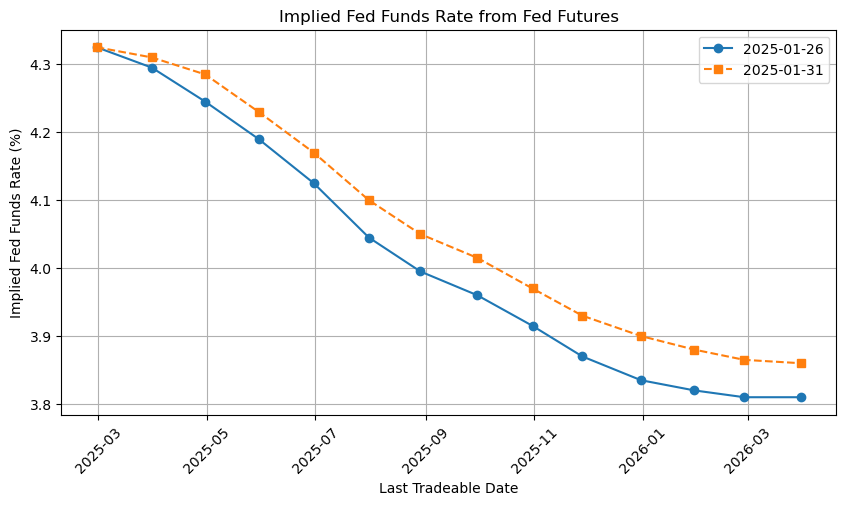

In [140]:
# Plot the implied Fed Funds rate curves
plt.figure(figsize=(10, 5))
plt.plot(fedfutures_2025_01_26["last_tradeable_dt"], fedfutures_2025_01_26["implied_rate"], marker="o", linestyle="-", label="2025-01-26")
plt.plot(fedfutures_2025_01_31["last_tradeable_dt"], fedfutures_2025_01_31["implied_rate"], marker="s", linestyle="--", label="2025-01-31")

plt.xlabel("Last Tradeable Date")
plt.ylabel("Implied Fed Funds Rate (%)")
plt.title("Implied Fed Funds Rate from Fed Futures")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [141]:
open_interest = fedfutures_2025_01_31[["ticker", "open_int"]]
print("Open Interest on 2025-01-31:")
print(open_interest)

Open Interest on 2025-01-31:
         ticker  open_int
0   FFG5 Comdty    503574
1   FFH5 Comdty    320421
2   FFJ5 Comdty    318741
3   FFK5 Comdty    360361
4   FFM5 Comdty    156189
5   FFN5 Comdty    194301
6   FFQ5 Comdty     70271
7   FFU5 Comdty     46060
8   FFV5 Comdty     52800
9   FFX5 Comdty     28439
10  FFZ5 Comdty     14771
11  FFF6 Comdty     21311
12  FFG6 Comdty      5135
13  FFH6 Comdty      1167


**Open interest seems to decline as we encounter bonds with long maturities.**

### 2.2 Extracting the Expected Path of Fed Funds Rates

Assume the Fed...
* sets the rate exactly at its list of meeting dates.
* does not change the rate betweeen meeting dates.

Use the present data to calculate--and plot--the implied set of expected Fed Funds rates as of each meeting date.

#### Technical Point
* Consider months, $t$, where there is a meeting, but such that in month $t+1$ there is no meeting.
* There will be two reasonable ways to extract the expected fed funds rate:
    1. Use the futures rate from the $t+1$-contract
    2. Calculate the implied rate for the remainder of month $t$, knowing the expected rate at the end of month $t+1$.
* These are both reasonable and will likely not differ much.

Try to make reasonable assumptions as needed. to implement the calculation.

In [142]:
fedfutures_fedmeetings["meeting dates"] = pd.to_datetime(fedfutures_fedmeetings["meeting dates"])

futures_data = fedfutures_2025_01_31[["last_tradeable_dt", "px_last"]].copy()
futures_data["last_tradeable_dt"] = pd.to_datetime(futures_data["last_tradeable_dt"])
futures_data["implied_rate"] = 100 - futures_data["px_last"]

expected_rates = pd.merge_asof(fedfutures_fedmeetings.sort_values("meeting dates"),
                               futures_data.sort_values("last_tradeable_dt"),
                               left_on="meeting dates",
                               right_on="last_tradeable_dt",
                               direction="forward")


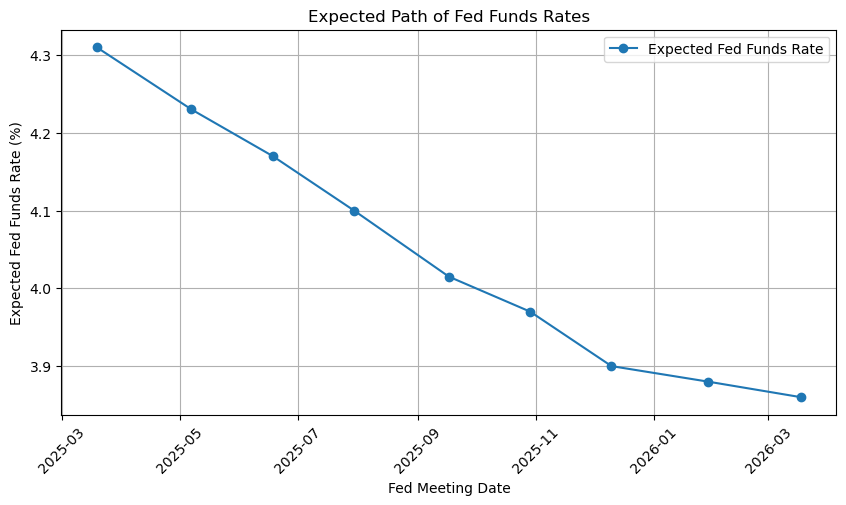

In [143]:
# Plot expected Fed Funds rate path
plt.figure(figsize=(10, 5))
plt.plot(expected_rates["meeting dates"], expected_rates["implied_rate"], marker="o", linestyle="-", label="Expected Fed Funds Rate")

# Labels and title
plt.xlabel("Fed Meeting Date")
plt.ylabel("Expected Fed Funds Rate (%)")
plt.title("Expected Path of Fed Funds Rates")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

### 2.3 Compare to the Historic Curve

Use the price data in `2024` to extract the expectations at the previous date.
* Note that you do not need to "bootstrap" up from the historic date to the current date. 

Compare this to the answer in the previous problem, for the current data.

In [ ]:
futures_data_2024 = fedfutures_2024_07_29[["last_tradeable_dt", "px_last"]].copy()
futures_data_2024["last_tradeable_dt"] = pd.to_datetime(futures_data_2024["last_tradeable_dt"])
futures_data_2024["implied_rate"] = 100 - futures_data_2024["px_last"]

expected_rates_2024 = pd.merge_asof(
    fedfutures_fedmeetings.sort_values("meeting dates"),
    futures_data_2024.sort_values("last_tradeable_dt"),
    left_on="meeting dates",
    right_on="last_tradeable_dt",
    direction="forward"
)

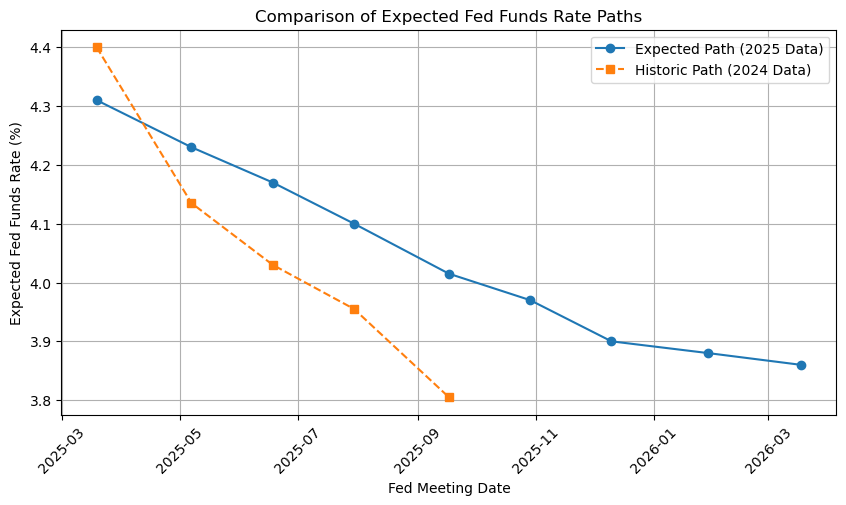

In [145]:
# Plot comparison of expected Fed Funds rate paths
plt.figure(figsize=(10, 5))
plt.plot(expected_rates["meeting dates"], expected_rates["implied_rate"], marker="o", linestyle="-", label="Expected Path (2025 Data)")
plt.plot(expected_rates_2024["meeting dates"], expected_rates_2024["implied_rate"], marker="s", linestyle="--", label="Historic Path (2024 Data)")

# Labels and title
plt.xlabel("Fed Meeting Date")
plt.ylabel("Expected Fed Funds Rate (%)")
plt.title("Comparison of Expected Fed Funds Rate Paths")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

***